# Práctica 4: Entrenamiento de redes neuronales

In [1]:
# Library imports
import numpy as np
from pandas.io.parsers import read_csv
from matplotlib import pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import operator
from displayData import displayData
from checkNNGradients import *

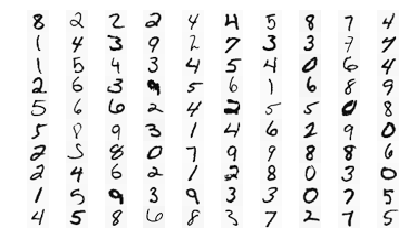

In [2]:
# Loading data
data = loadmat('ex4data1.mat')

y = data['y'].ravel()
X = data['X']
X_ones = np.hstack([np.ones([X.shape[0], 1]), X])

INIT_EPSILON = 0.01

# Loading weights
weights = loadmat('ex4weights.mat')
theta1_best, theta2_best = weights['Theta1'], weights['Theta2']

# Displaying data
sample = np.random.choice(X.shape[0], 100)
imgs = displayData(X[sample, :])

In [3]:
y=(y-1)
y_onehot=np.zeros((X.shape[0],10))#5000x10
for i in range(X.shape[0]):
    y_onehot[i][y[i]]=1

In [4]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

def random_weights(L_in, L_out, epsilon = 0.12):
    return np.random.random((L_in, L_out)) * (2 * epsilon) - epsilon

# Forward propagation
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]

    a1 = np.hstack([np.ones([m, 1]), X])
    z2 = np.dot(a1, theta1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoid(z2)])
    z3 = np.dot(a2, theta2.T)
    h = sigmoid(z3)

    return a1, z2, a2, z3, h

In [5]:
# Gradient function
def gradient(x, y):
    m = x.shape[0]
    random_theta1 = random_weights(5, x.shape[1]+1)
    random_theta2 = random_weights(y.shape[1], 6)

    delta1 = 0
    delta2 = 0

    a1, z2, a2, z3, h = forward_propagate(x, random_theta1, random_theta2)

    
    #print("Theta1:{}".format(random_theta1.shape))
    #print("Theta2:{}".format(random_theta2.shape))
    
    for t in range(m):    
        a1t = a1[t, :] 
        #print("A1:{}".format(a1.shape))
        a2t = a2[t, :] 
        #print("A2:{}".format(a2.shape))
        ht = h[t, :]  
        #print("H:{}".format(ht.shape))
        yt = y[t]  
        #print("yt:{}".format(yt.shape))        
        d3t = ht - yt  
        #print("d3t:{}".format(d3t.shape))        
        d2t = np.dot(random_theta2.T, d3t) * (a2t * (1 - a2t)) 
        #print("d2t:{}".format(d2t.shape))
        delta1 = delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        #print("delta1:{}".format(delta1.shape))
        delta2 = delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
        #print("delta2:{}".format(delta2.shape))
    
    return np.concatenate((np.ravel(delta1 / x.shape[0]) , np.ravel(delta2 / x.shape[0])))

In [6]:
def cost(X, y, theta1, theta2, num_etiquetas, reg=0):
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    m = X.shape[0]

    total = 0
    for i in range(m):
        for k in range(num_etiquetas):
            term_1 = - (np.log(h[i][k]) * y[i][k])
            term_2 = - (np.log(1 - h[i][k]) * (1 - y[i][k]))
            total = total + (term_1 + term_2)

    sum_theta1 = np.sum(np.square(theta1))
    sum_theta2 = np.sum(np.square(theta2))

    term_3 = (sum_theta1 + sum_theta2) * (reg / (2 * m))

    return (total / m) + term_3


In [7]:
# Cost function
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    """ backprop devuelve el coste y el gradiente de una red neuronal de dos capas """
    theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))

    return cost(X, y, theta1, theta2, num_etiquetas,1), gradient(X, y_onehot)

In [8]:
params_rn = np.concatenate((np.ravel(theta1_best), np.ravel(theta2_best)))
backprop(params_rn, 400, 25, 10, X, y_onehot, 1)[0]

0.38448779624289536

## Checkeo del gradiente

In [9]:
a = checkNNGradients(backprop, 0)

Shape expected: (38,)
Shape actual: (80,)


AssertionError: 
Arrays are not almost equal to 7 decimals

(shapes (80,), (38,) mismatch)
 x: array([-1.2578464e-05,  6.6099811e-07, -1.5541972e-06, -2.3404708e-06,
        2.5925011e-05, -1.3623595e-06,  3.2033007e-06,  4.8238610e-06,
       -6.0456093e-05,  3.1769668e-06, -7.4699672e-06, -1.1249048e-05,...
 y: array([ 0.0822085,  0.1698601,  0.1917435,  0.0373387, -0.2318394,
       -0.1724266, -0.089715 ,  0.0754802,  0.0590851,  0.109907 ,
       -0.1766227, -0.3007662, -0.1914065,  0.0905772,  0.1722064,...